In [3]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import seaborn as sns

This notebook is a demo to predict the age and life expectancy of a battery cell. It is a simplification of [this blog](https://towardsdatascience.com/predicting-battery-lifetime-with-cnns-c5e1faeecc8f), which is an implementation of [this paper](https://www.nature.com/articles/s41560-019-0356-8). The model created in this notebook uses a simple Random Forest Regressor. For further accuracy, a neural network could be used as mentioned in the article above.

The data used in the following cell can be found and/or created [here](https://github.com/dsr-18/long-live-the-battery#generate-local-data). 
`processed_data.pkl` needs `batch1.pkl`, `batch2.pkl` and `batch3.pkl`. To create these batch files, you will need the original batch files (.mat files).

In [4]:
file_path = 'data/processed_data.pkl'
with open(file_path, 'rb') as fp:
    data = pickle.load(fp)

`data` is a dictionary which has the following format:

- battery_cell_name
    - cycle_life: _int_
    - policy: _str_ of an _int_
    - summary: 
        - IR: List of internal resistances for each cycle
        - QD: List of discharge capacities for each cycle
        - Remaining_cycles: List of remaining cycles for each cycle
        - Discharge_time: List of discharge time for each cycle
    - cycles:
        - cycle_number:
            - Qdlin: List of capacities during this cycle
            - Tdlin: List of temperatures during this cycle
            - Vdlin: List of voltages during this cycle


In [5]:
# Convert cycles in dict to pandas DataFrame
def cycles_to_df(cell_data, cell_name):
    cycles = cell_data['cycles']
    df = pd.DataFrame.from_dict(cycles).transpose()
    df['cycle_life'] = cell_data['cycle_life']
    df['cell'] = cell_name
    
#     Include or exclude the policy key
    df['policy'] = cell_data['policy']

    # index is a str, convert to numeric type
    df.index = range(1, df.shape[0] + 1)
    return df

In [6]:
# Convert summary in dict to pandas DataFrame
def summary_to_df(summary):
    df = pd.DataFrame(summary)
    df.index = range(1, df.shape[0] + 1)
    return df

In [7]:
# Create a DataFrame out of the dictionary dataset

df = pd.DataFrame()
for i, cell in enumerate(data.keys()):
    cell_data = data[cell]
    summary = cell_data['summary']
    cycles = cell_data['cycles']
    
    df_cycles = cycles_to_df(cell_data, cell)
    df_summary = summary_to_df(summary)
    df_inner = df_cycles.join(df_summary)
    df = pd.concat([df, df_inner])
    

df.index.name = 'cycle_number'

In [8]:
# Print the amount of samples and amount of current features/columns

print(df.shape)
df.head(10)

(98822, 10)


,Qdlin,Tdlin,Vdlin,cycle_life,cell,policy,IR,QD,Remaining_cycles,Discharge_time
cycle_number,,,,,,,,,,
1,"[0.00012781235, 0.00012781235, 0.00012781235, ...","[29.585907, 29.585907, 29.585907, 29.585907, 2...","[3.5, 3.4984984984984986, 3.496996996996997, 3...",1852.0,b1c0,3,0.016742,1.070689,1851.0,14.377020
2,"[0.00075522717, 0.00075522717, 0.00075522717, ...","[29.645998, 29.645998, 29.645998, 29.645998, 2...","[3.5, 3.4984984984984986, 3.496996996996997, 3...",1852.0,b1c0,3,0.016724,1.071900,1850.0,14.396222
3,"[8.7441702e-05, 8.7441702e-05, 8.7441702e-05, ...","[29.744202, 29.744202, 29.744202, 29.744202, 2...","[3.5, 3.4984984984984986, 3.496996996996997, 3...",1852.0,b1c0,3,0.016681,1.072510,1849.0,14.406947
4,"[0.00063289498, 0.00063289498, 0.00063289498, ...","[29.644709, 29.644709, 29.644709, 29.644709, 2...","[3.5, 3.4984984984984986, 3.496996996996997, 3...",1852.0,b1c0,3,0.016662,1.073174,1848.0,14.416888
5,"[3.9169303e-05, 3.9169303e-05, 3.9169303e-05, ...","[29.752932, 29.752932, 29.752932, 29.752932, 2...","[3.5, 3.4984984984984986, 3.496996996996997, 3...",1852.0,b1c0,3,0.016623,1.073576,1847.0,14.423143
6,"[0.00074284745, 0.00074284745, 0.00074284745, ...","[29.642483, 29.642483, 29.642483, 29.642483, 2...","[3.5, 3.4984984984984986, 3.496996996996997, 3...",1852.0,b1c0,3,0.016600,1.073992,1846.0,14.425528
7,"[0.00018595935, 0.00018595935, 0.00018595935, ...","[29.670431, 29.670431, 29.670431, 29.670431, 2...","[3.5, 3.4984984984984986, 3.496996996996997, 3...",1852.0,b1c0,3,0.016577,1.074374,1845.0,14.432453
8,"[0.00088375231, 0.00088375231, 0.00088375231, ...","[29.687721, 29.687721, 29.687721, 29.687721, 2...","[3.5, 3.4984984984984986, 3.496996996996997, 3...",1852.0,b1c0,3,0.016588,1.074492,1844.0,14.434373
9,"[9.7539247e-05, 9.7539247e-05, 9.7539247e-05, ...","[29.739122, 29.739122, 29.739122, 29.739122, 2...","[3.5, 3.4984984984984986, 3.496996996996997, 3...",1852.0,b1c0,3,0.016572,1.074537,1843.0,14.436853


The data is sampled according to a difference in voltage, since the time for charging and discharging each battery differs with every cycle. The voltage range for each cycle goes from 3.5V to 2V, which makes it a good choice to base our samples upon. Over this complete range, 1000 samples are created. This means that Vdlin is a linear descending feature, Qdlin and Tdlin are samples based on the same timestamps where these voltages occur.

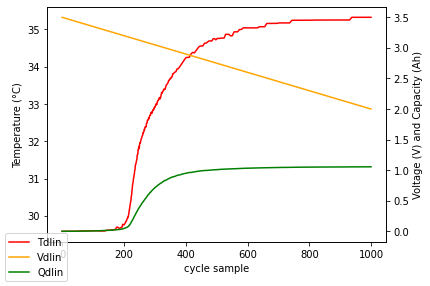

In [9]:
# Plot the 3 linearly distributed cycle-based features:
# Vdlin
# Qdlin
# Tdlin

%matplotlib inline
from IPython import display

fig, ax1 = plt.subplots()

ax1.set_xlabel('cycle sample')
ax1.set_ylabel('Temperature (°C)')
ax1.plot(df.Tdlin.iloc[0], label='Tdlin', color='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Voltage (V) and Capacity (Ah)')
ax2.plot(df.Vdlin.iloc[0], label='Vdlin', color='orange')
ax2.plot(df.Qdlin.iloc[0], label='Qdlin', color='green')

fig.tight_layout()
fig.legend(loc="lower left")
plt.show()

In [10]:
# This cell is a little bugged, but shows the range of the features

# %matplotlib inline
# from IPython import display

# fig, ax1 = plt.subplots()

# ax1.set_xlabel('cycle sample')
# ax1.set_ylabel('Temperature (°C)')
# ax2 = ax1.twinx()
# ax2.set_ylabel('Voltage (V) and Capacity (Ah)')
# fig.tight_layout()
# fig.legend(loc="lower left")

# for i in range(100):
#     plt.sca(ax1)
#     plt.plot(df.Tdlin.iloc[i], label='Tdlin', color='red')
    
#     plt.sca(ax2)
#     plt.plot(df.Vdlin.iloc[i], label='Vdlin', color='orange')
#     plt.plot(df.Qdlin.iloc[i], label='Qdlin', color='green')

#     display.clear_output(wait=True)
#     print(i, end='\r')
#     plt.show()
#     plt.pause(0.01)
# #     plt.show()

The plot below shows the discharge rate of the battery.

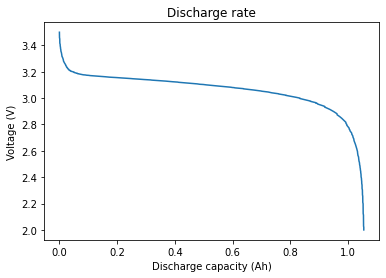

In [11]:
plt.plot(df.Qdlin.iloc[0], df.Vdlin.iloc[0])
plt.title('Discharge rate')
plt.xlabel('Discharge capacity (Ah)')
plt.ylabel('Voltage (V)')
plt.show()

In [12]:
# # THIS CELL WILL LOOP THROUGH ALL CELLS AND CYCLE NUMBERS AND DISPLAY THE DISCHARGE RATE.
# # THIS TAKES ABOUT 35 SECONDS

# %matplotlib inline
# from IPython import display

# fig, ax1 = plt.subplots()

# for i in range(0, 1850, 10):
#     plt.plot(df.Qdlin.iloc[i], df.Vdlin.iloc[i])
#     plt.title('Discharge rate')
#     plt.xlabel('Discharge capacity (Ah)')
#     plt.ylabel('Voltage (V)')
#     display.clear_output(wait=True)
#     print(i, end='\r')
#     plt.show()
#     plt.pause(0.05)
    

In [13]:
original_df = df.copy()

In [14]:
# Use cell and cycle_number as a multi-index

df = df.reset_index()
df = df.set_index(['cell', 'cycle_number'])
df.head()

Qdlin  \
cell cycle_number                                                      
b1c0 1             [0.00012781235, 0.00012781235, 0.00012781235, ...   
     2             [0.00075522717, 0.00075522717, 0.00075522717, ...   
     3             [8.7441702e-05, 8.7441702e-05, 8.7441702e-05, ...   
     4             [0.00063289498, 0.00063289498, 0.00063289498, ...   
     5             [3.9169303e-05, 3.9169303e-05, 3.9169303e-05, ...   

                                                               Tdlin  \
cell cycle_number                                                      
b1c0 1             [29.585907, 29.585907, 29.585907, 29.585907, 2...   
     2             [29.645998, 29.645998, 29.645998, 29.645998, 2...   
     3             [29.744202, 29.744202, 29.744202, 29.744202, 2...   
     4             [29.644709, 29.644709, 29.644709, 29.644709, 2...   
     5             [29.752932, 29.752932, 29.752932, 29.752932, 2...   

                                                               Vdlin  \
cell cycle_number                                                      
b1c0 1             [3.5, 3.4984984984984986, 3.496996996996997, 3...   
     2             [3.5, 3.4984984984984986, 3.496996996996997, 3...   
     3             [3.5, 3.4984984984984986, 3.496996996996997, 3...   
     4             [3.5, 3.4984984984984986, 3.496996996996997, 3...   
     5             [3.5, 3.4984984984984986, 3.496996996996997, 3...   

                   cycle_life policy        IR        QD  Remaining_cycles  \
cell cycle_number                                                            
b1c0 1                 1852.0      3  0.016742  1.070689            1851.0   
     2                 1852.0      3  0.016724  1.071900            1850.0   
     3                 1852.0      3  0.016681  1.072510            1849.0   
     4                 1852.0      3  0.016662  1.073174            1848.0   
     5                 1852.0      3  0.016623  1.073576            1847.0   

                   Discharge_time  
cell cycle_number                  
b1c0 1                  14.377020  
     2                  14.396222  
     3                  14.406947  
     4                  14.416888  
     5                  14.423143

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 98822 entries, ('b1c0', 1) to ('b3c45', 1799)
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Qdlin             98822 non-null  object 
 1   Tdlin             98822 non-null  object 
 2   Vdlin             98822 non-null  object 
 3   cycle_life        98822 non-null  float64
 4   policy            98822 non-null  object 
 5   IR                98822 non-null  float64
 6   QD                98822 non-null  float64
 7   Remaining_cycles  98822 non-null  float64
 8   Discharge_time    98822 non-null  float64
dtypes: float64(5), object(4)
memory usage: 7.2+ MB


In [16]:
df.describe()

,cycle_life,IR,QD,Remaining_cycles,Discharge_time
count,98822.000000,98822.000000,98822.000000,98822.000000,98822.000000
mean,971.037158,0.016590,1.033611,485.798152,13.535397
std,455.332317,0.001234,0.048867,384.043812,0.889094
min,148.000000,0.000000,0.874198,0.000000,6.280923
25%,648.000000,0.015566,1.016400,200.000000,13.188018
50%,862.000000,0.016588,1.050074,403.000000,13.797432
75%,1078.000000,0.017333,1.067931,675.000000,14.178830
max,2237.000000,0.023757,2.884085,2236.000000,24.197272


In [17]:
df.head()

Qdlin  \
cell cycle_number                                                      
b1c0 1             [0.00012781235, 0.00012781235, 0.00012781235, ...   
     2             [0.00075522717, 0.00075522717, 0.00075522717, ...   
     3             [8.7441702e-05, 8.7441702e-05, 8.7441702e-05, ...   
     4             [0.00063289498, 0.00063289498, 0.00063289498, ...   
     5             [3.9169303e-05, 3.9169303e-05, 3.9169303e-05, ...   

                                                               Tdlin  \
cell cycle_number                                                      
b1c0 1             [29.585907, 29.585907, 29.585907, 29.585907, 2...   
     2             [29.645998, 29.645998, 29.645998, 29.645998, 2...   
     3             [29.744202, 29.744202, 29.744202, 29.744202, 2...   
     4             [29.644709, 29.644709, 29.644709, 29.644709, 2...   
     5             [29.752932, 29.752932, 29.752932, 29.752932, 2...   

                                                               Vdlin  \
cell cycle_number                                                      
b1c0 1             [3.5, 3.4984984984984986, 3.496996996996997, 3...   
     2             [3.5, 3.4984984984984986, 3.496996996996997, 3...   
     3             [3.5, 3.4984984984984986, 3.496996996996997, 3...   
     4             [3.5, 3.4984984984984986, 3.496996996996997, 3...   
     5             [3.5, 3.4984984984984986, 3.496996996996997, 3...   

                   cycle_life policy        IR        QD  Remaining_cycles  \
cell cycle_number                                                            
b1c0 1                 1852.0      3  0.016742  1.070689            1851.0   
     2                 1852.0      3  0.016724  1.071900            1850.0   
     3                 1852.0      3  0.016681  1.072510            1849.0   
     4                 1852.0      3  0.016662  1.073174            1848.0   
     5                 1852.0      3  0.016623  1.073576            1847.0   

                   Discharge_time  
cell cycle_number                  
b1c0 1                  14.377020  
     2                  14.396222  
     3                  14.406947  
     4                  14.416888  
     5                  14.423143

In [18]:
df.tail()

Qdlin  \
cell  cycle_number                                                      
b3c45 1795          [9.6732394e-05, 9.6732394e-05, 9.6732394e-05, ...   
      1796          [5.3448484e-06, 5.3448484e-06, 5.3448484e-06, ...   
      1797          [0.00081231183, 0.00081231183, 0.00081231183, ...   
      1798          [0.00075293891, 0.00075293891, 0.00075293891, ...   
      1799          [0.00059676042, 0.00059676042, 0.00059676042, ...   

                                                                Tdlin  \
cell  cycle_number                                                      
b3c45 1795          [30.408115428187518, 30.408115428187518, 30.40...   
      1796          [29.87577217993123, 29.87577217993123, 29.8757...   
      1797          [31.49014181530497, 31.49014181530497, 31.4901...   
      1798          [29.58836362094141, 29.58836362094141, 29.5883...   
      1799          [31.9548847490178, 31.9548847490178, 31.954884...   

                                                                Vdlin  \
cell  cycle_number                                                      
b3c45 1795          [3.5, 3.4984984984984986, 3.496996996996997, 3...   
      1796          [3.5, 3.4984984984984986, 3.496996996996997, 3...   
      1797          [3.5, 3.4984984984984986, 3.496996996996997, 3...   
      1798          [3.5, 3.4984984984984986, 3.496996996996997, 3...   
      1799          [3.5, 3.4984984984984986, 3.496996996996997, 3...   

                    cycle_life policy        IR        QD  Remaining_cycles  \
cell  cycle_number                                                            
b3c45 1795              1801.0      4  0.017538  0.881539               6.0   
      1796              1801.0      4  0.017294  0.881441               5.0   
      1797              1801.0      4  0.017605  0.880883               4.0   
      1798              1801.0      4  0.017526  0.880757               3.0   
      1799              1801.0      4  0.017456  0.880473               2.0   

                    Discharge_time  
cell  cycle_number                  
b3c45 1795               11.439532  
      1796               11.395382  
      1797               11.398232  
      1798               11.417975  
      1799               11.370393

In [19]:
# Show the amount of batteries we have data for

df.index.get_level_values('cell').unique().shape

(124,)

In [20]:
# Policy for each cell in the dataset

for cell in df.policy.groupby(level='cell').unique().iteritems():
    print(cell[0], cell[1])

b1c0 ['3']
b1c1 ['3']
b1c11 ['5']
b1c14 ['5']
b1c15 ['5']
b1c16 ['5']
b1c17 ['5']
b1c18 ['5']
b1c19 ['5']
b1c2 ['3']
b1c20 ['5']
b1c21 ['5']
b1c23 ['6']
b1c24 ['6']
b1c25 ['6']
b1c26 ['6']
b1c27 ['6']
b1c28 ['6']
b1c29 ['6']
b1c3 ['4']
b1c30 ['6']
b1c31 ['6']
b1c32 ['6']
b1c33 ['6']
b1c34 ['7']
b1c35 ['7']
b1c36 ['7']
b1c37 ['7']
b1c38 ['7']
b1c39 ['7']
b1c4 ['4']
b1c40 ['8']
b1c41 ['8']
b1c42 ['8']
b1c43 ['8']
b1c44 ['8']
b1c45 ['8']
b1c5 ['4']
b1c6 ['4']
b1c7 ['4']
b1c9 ['5']
b2c0 ['1']
b2c1 ['2']
b2c10 ['3']
b2c11 ['4']
b2c12 ['4']
b2c13 ['4']
b2c14 ['4']
b2c17 ['4']
b2c18 ['4']
b2c19 ['4']
b2c2 ['2']
b2c20 ['4']
b2c21 ['4']
b2c22 ['4']
b2c23 ['4']
b2c24 ['4']
b2c25 ['4']
b2c26 ['4']
b2c27 ['4']
b2c28 ['4']
b2c29 ['4']
b2c3 ['2']
b2c30 ['5']
b2c31 ['5']
b2c32 ['5']
b2c33 ['5']
b2c34 ['5']
b2c35 ['5']
b2c36 ['5']
b2c37 ['5']
b2c38 ['5']
b2c39 ['5']
b2c4 ['3']
b2c40 ['5']
b2c41 ['5']
b2c42 ['6']
b2c43 ['6']
b2c44 ['6']
b2c45 ['6']
b2c46 ['6']
b2c47 ['6']
b2c5 ['3']
b2c6 ['3']
b3c0 ['5

In [21]:
# Add new features from Qdlin, Tdlin, Vdlin
df['Qdlin_mean'] = df['Qdlin'].map(lambda x: np.mean(x))
df['Qdlin_first'] = df['Qdlin'].map(lambda x: x[0])
df['Qdlin_last'] = df['Qdlin'].map(lambda x: x[-1])
df['Qdlin_median'] = df['Qdlin'].map(lambda x: np.median(x))
df['Qdlin_25p'] = df['Qdlin'].map(lambda x: x[250])
df['Qdlin_75p'] = df['Qdlin'].map(lambda x: x[750])
df['Qdlin_0.1'] = df['Qdlin'].map(lambda x: np.argmax(np.array(x) > 0.1))
df['Qdlin_0.9'] = df['Qdlin'].map(lambda x: np.argmax(np.array(x) > 0.9))

df['Vdlin_mean'] = df['Vdlin'].map(lambda x: np.mean(x))
df['Vdlin_first'] = df['Vdlin'].map(lambda x: x[0])
df['Vdlin_last'] = df['Vdlin'].map(lambda x: x[-1])

df['Tdlin_mean'] = df['Tdlin'].map(lambda x: np.mean(x))
df['Tdlin_first'] = df['Tdlin'].map(lambda x: x[0])
df['Tdlin_last'] = df['Tdlin'].map(lambda x: x[-1])

# Categorize the policy column, which contains str values at this moment
df['policy'] = df['policy'].astype('category').cat.codes


df.head()

Qdlin  \
cell cycle_number                                                      
b1c0 1             [0.00012781235, 0.00012781235, 0.00012781235, ...   
     2             [0.00075522717, 0.00075522717, 0.00075522717, ...   
     3             [8.7441702e-05, 8.7441702e-05, 8.7441702e-05, ...   
     4             [0.00063289498, 0.00063289498, 0.00063289498, ...   
     5             [3.9169303e-05, 3.9169303e-05, 3.9169303e-05, ...   

                                                               Tdlin  \
cell cycle_number                                                      
b1c0 1             [29.585907, 29.585907, 29.585907, 29.585907, 2...   
     2             [29.645998, 29.645998, 29.645998, 29.645998, 2...   
     3             [29.744202, 29.744202, 29.744202, 29.744202, 2...   
     4             [29.644709, 29.644709, 29.644709, 29.644709, 2...   
     5             [29.752932, 29.752932, 29.752932, 29.752932, 2...   

                                                               Vdlin  \
cell cycle_number                                                      
b1c0 1             [3.5, 3.4984984984984986, 3.496996996996997, 3...   
     2             [3.5, 3.4984984984984986, 3.496996996996997, 3...   
     3             [3.5, 3.4984984984984986, 3.496996996996997, 3...   
     4             [3.5, 3.4984984984984986, 3.496996996996997, 3...   
     5             [3.5, 3.4984984984984986, 3.496996996996997, 3...   

                   cycle_life  policy        IR        QD  Remaining_cycles  \
cell cycle_number                                                             
b1c0 1                 1852.0       2  0.016742  1.070689            1851.0   
     2                 1852.0       2  0.016724  1.071900            1850.0   
     3                 1852.0       2  0.016681  1.072510            1849.0   
     4                 1852.0       2  0.016662  1.073174            1848.0   
     5                 1852.0       2  0.016623  1.073576            1847.0   

                   Discharge_time  Qdlin_mean  ...  Qdlin_25p  Qdlin_75p  \
cell cycle_number                              ...                         
b1c0 1                  14.377020    0.744507  ...   0.391465   1.047537   
     2                  14.396222    0.745823  ...   0.394674   1.048207   
     3                  14.406947    0.746218  ...   0.397472   1.048958   
     4                  14.416888    0.747105  ...   0.399475   1.050184   
     5                  14.423143    0.747735  ...   0.400813   1.049992   

                   Qdlin_0.1  Qdlin_0.9  Vdlin_mean  Vdlin_first  Vdlin_last  \
cell cycle_number                                                              
b1c0 1                   218        366        2.75          3.5         2.0   
     2                   218        363        2.75          3.5         2.0   
     3                   218        362        2.75          3.5         2.0   
     4                   217        362        2.75          3.5         2.0   
     5                   217        360        2.75          3.5         2.0   

                   Tdlin_mean  Tdlin_first  Tdlin_last  
cell cycle_number                                       
b1c0 1              33.466525    29.585907   35.322502  
     2              33.518572    29.645998   35.406540  
     3              33.520907    29.744202   35.434151  
     4              33.530080    29.644709   35.383823  
     5              33.548649    29.752932   35.437229  

[5 rows x 23 columns]

<AxesSubplot:>

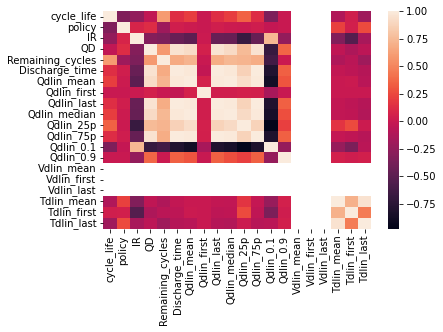

In [22]:
# Find correlations of cycle_life

sns.heatmap(df.corr())

In [23]:
df.corr().cycle_life.sort_values(ascending=False)

cycle_life          1.000000
Remaining_cycles    0.593375
Qdlin_25p           0.348828
Qdlin_mean          0.202144
Qdlin_median        0.198642
Discharge_time      0.132099
Qdlin_last          0.131190
Qdlin_75p           0.123169
Tdlin_first         0.040977
Qdlin_0.9          -0.001021
Qdlin_first        -0.002161
QD                 -0.036223
Tdlin_mean         -0.115380
Tdlin_last         -0.189924
IR                 -0.252251
policy             -0.341799
Qdlin_0.1          -0.347145
Vdlin_mean               NaN
Vdlin_first              NaN
Vdlin_last               NaN
Name: cycle_life, dtype: float64

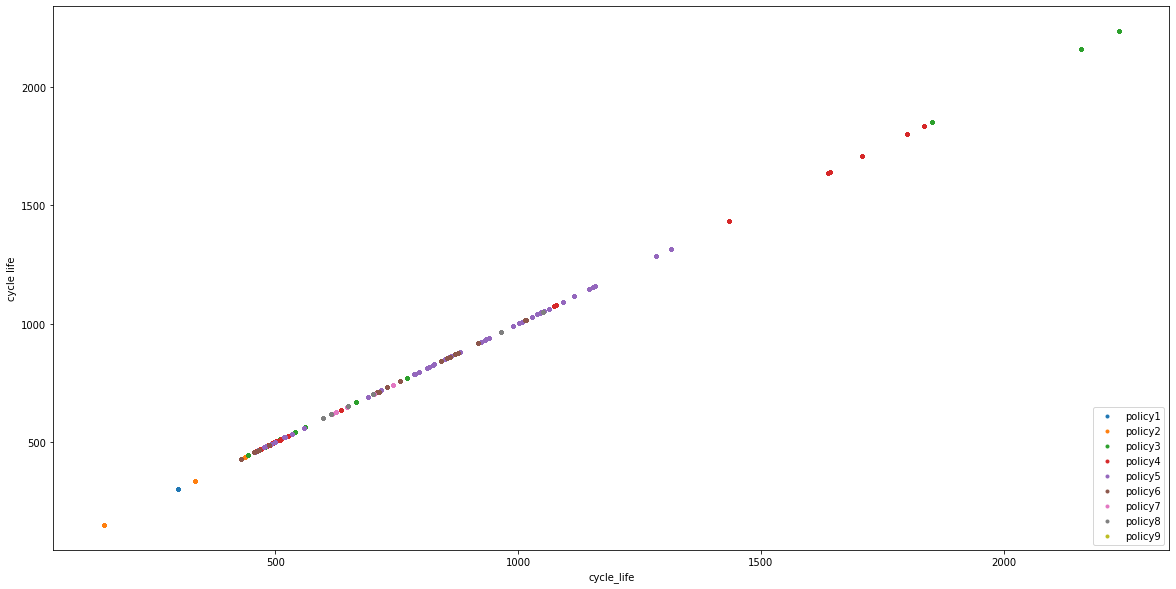

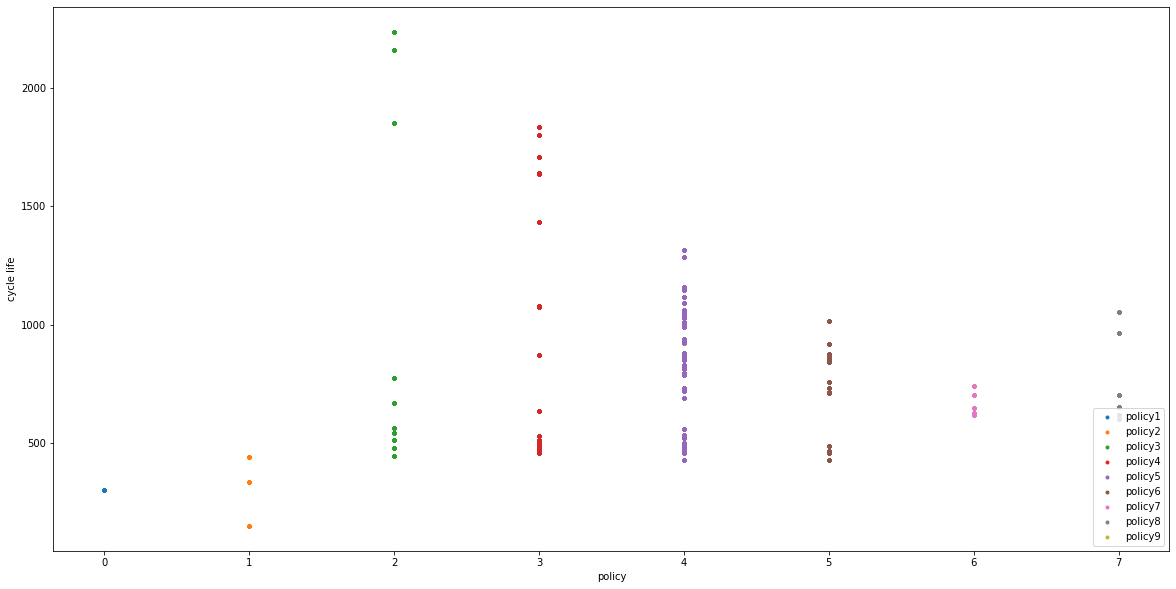

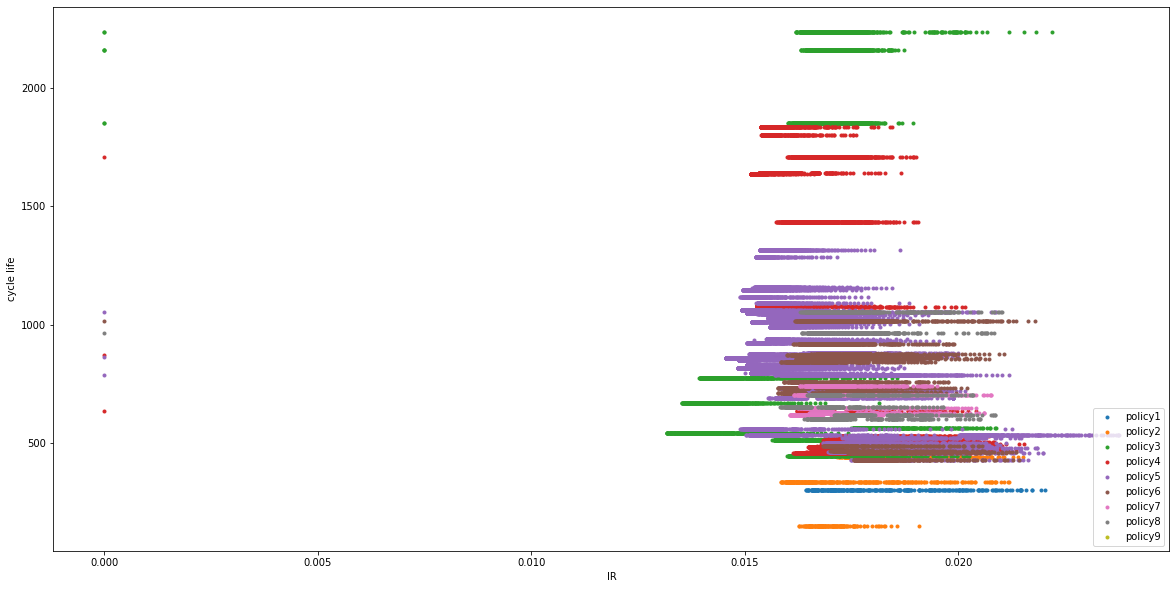

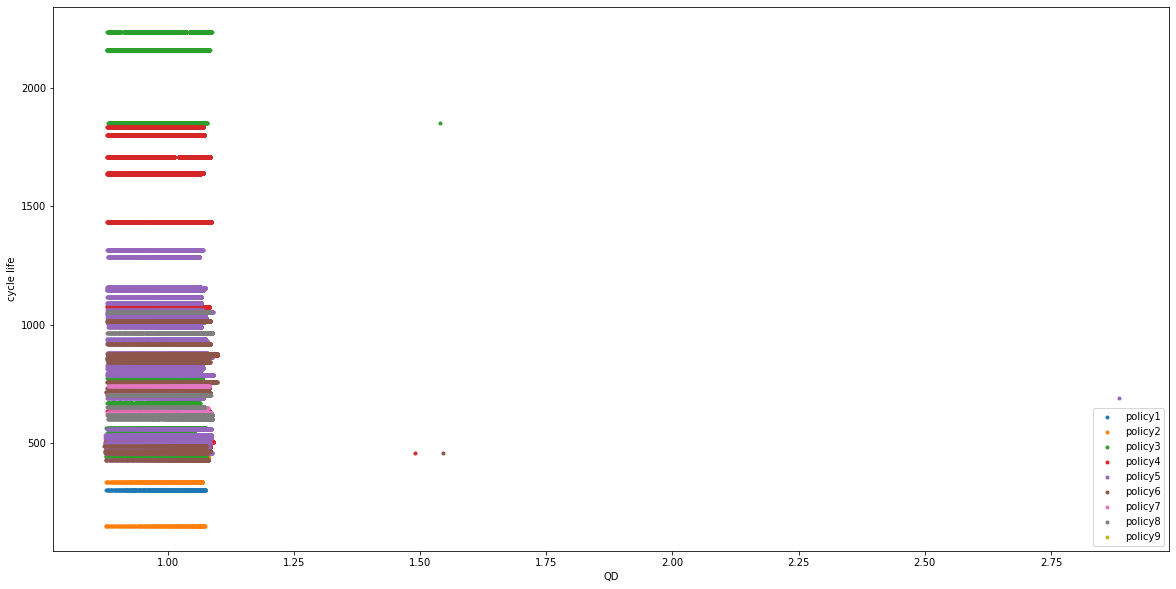

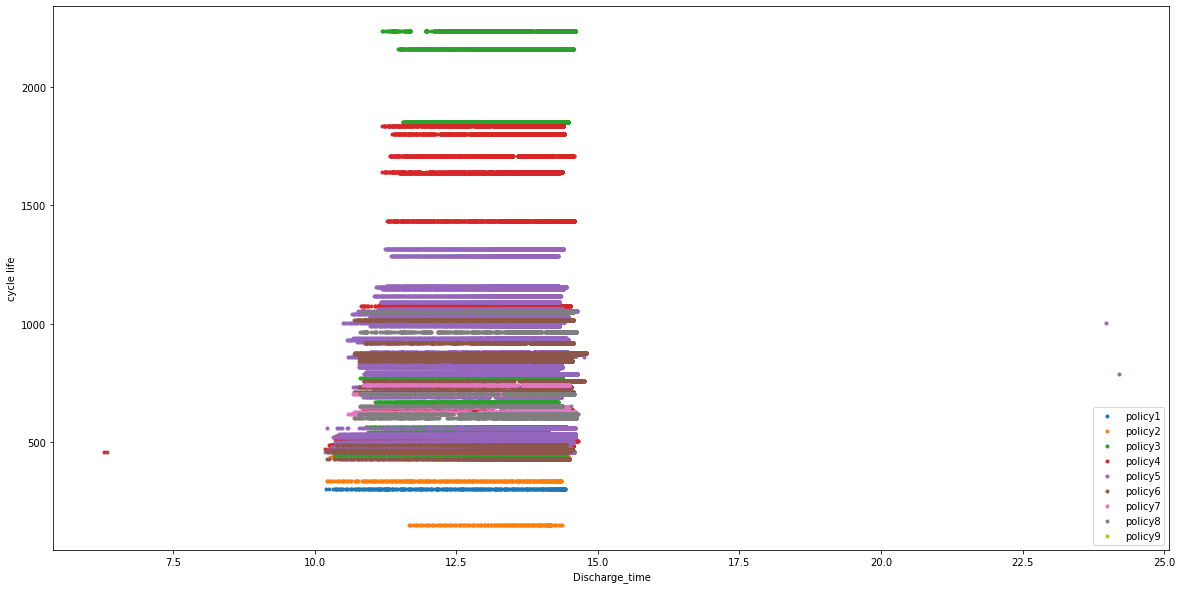

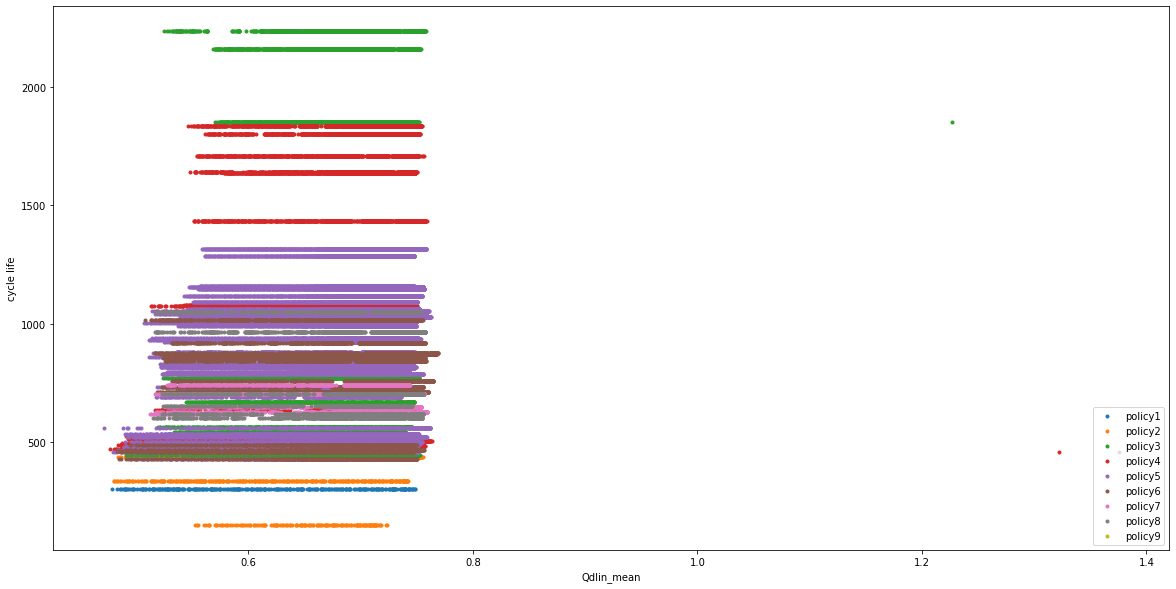

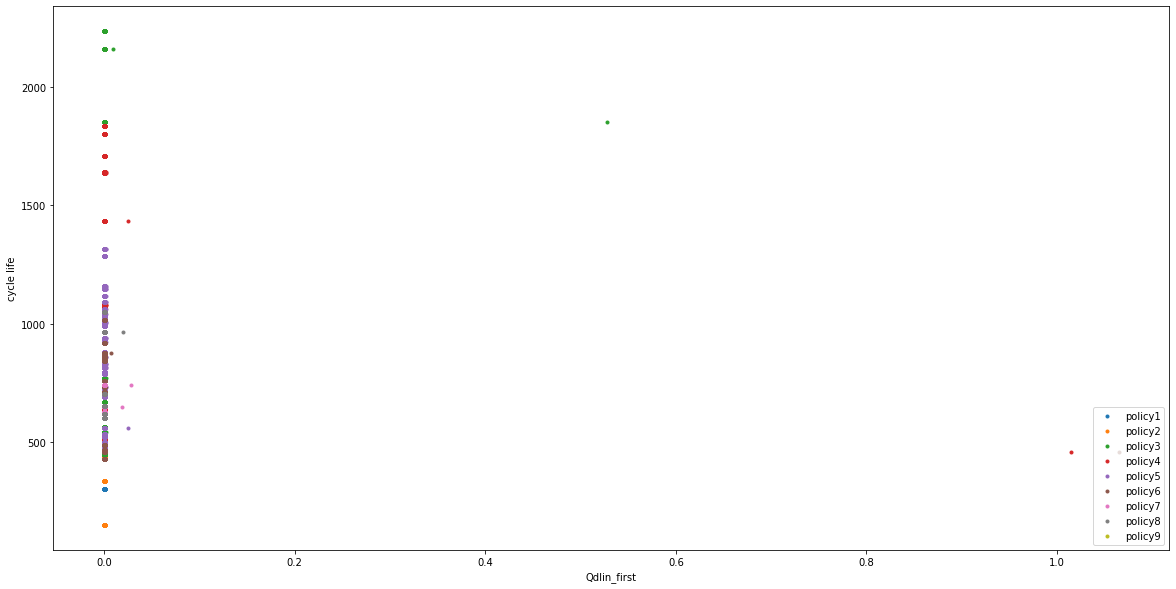

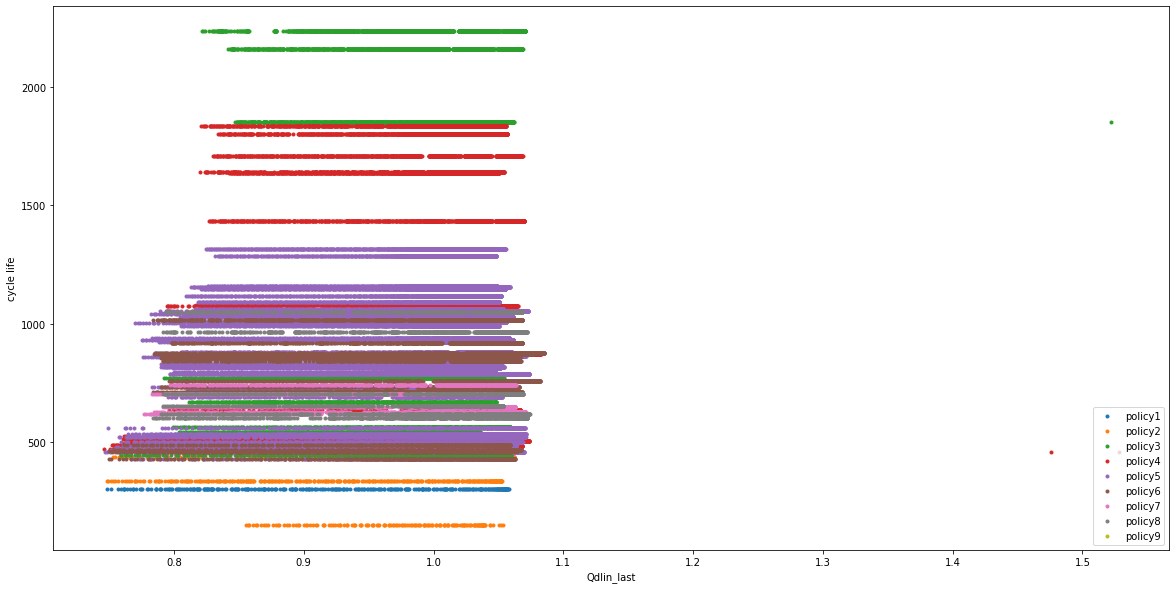

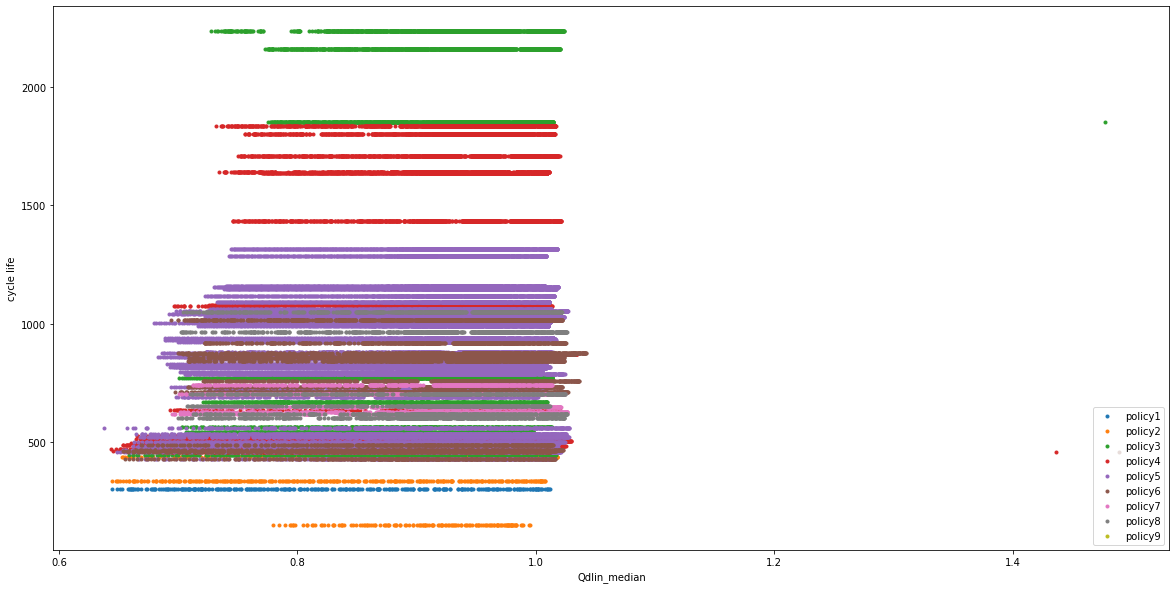

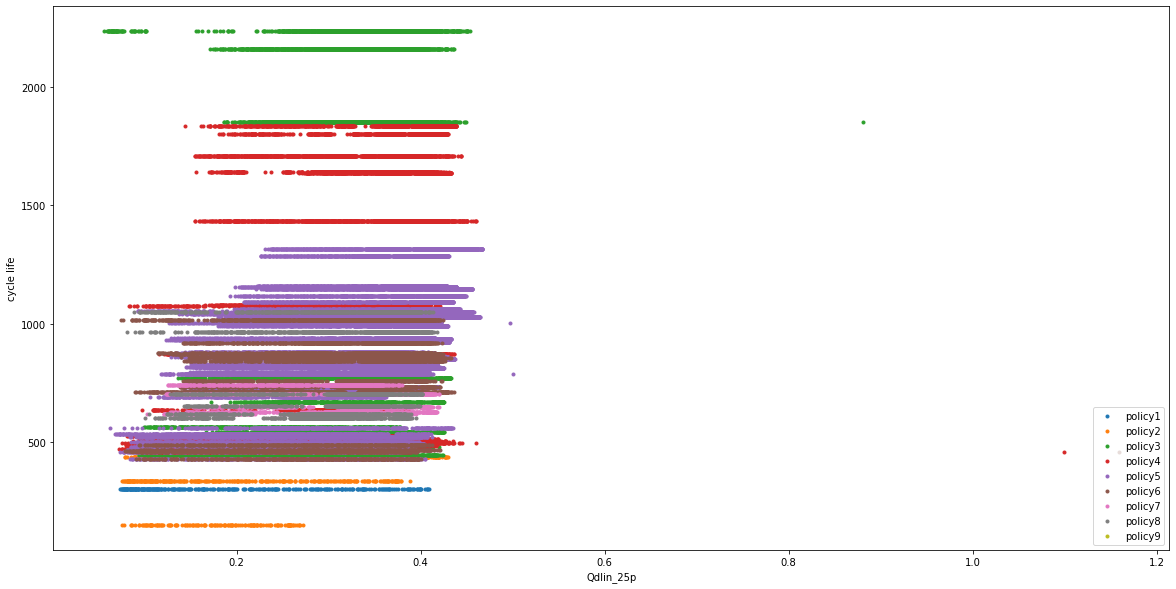

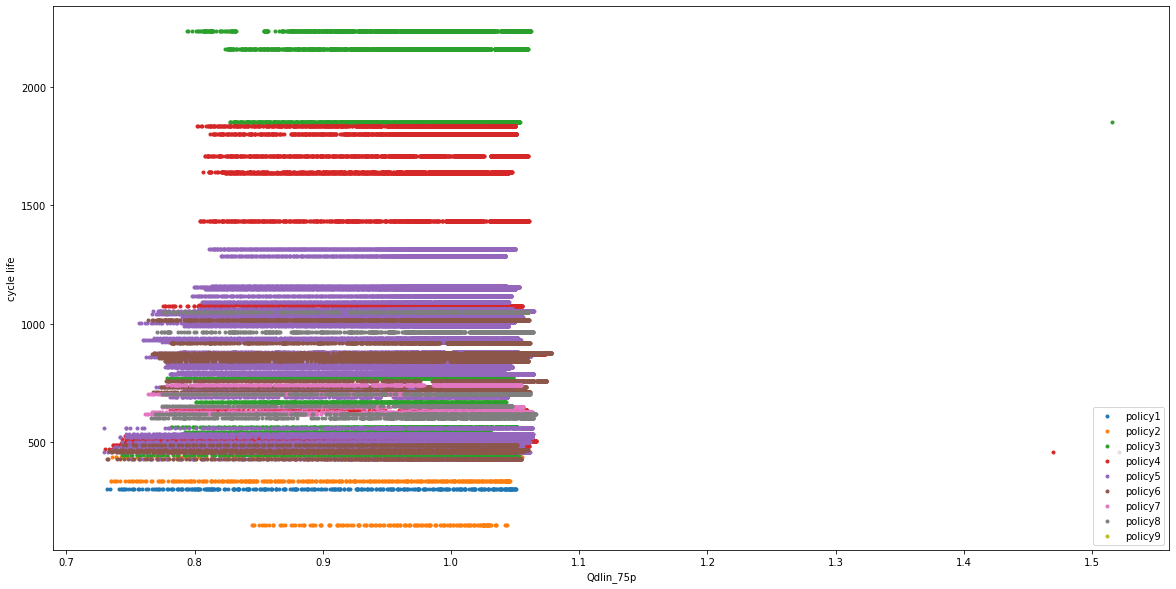

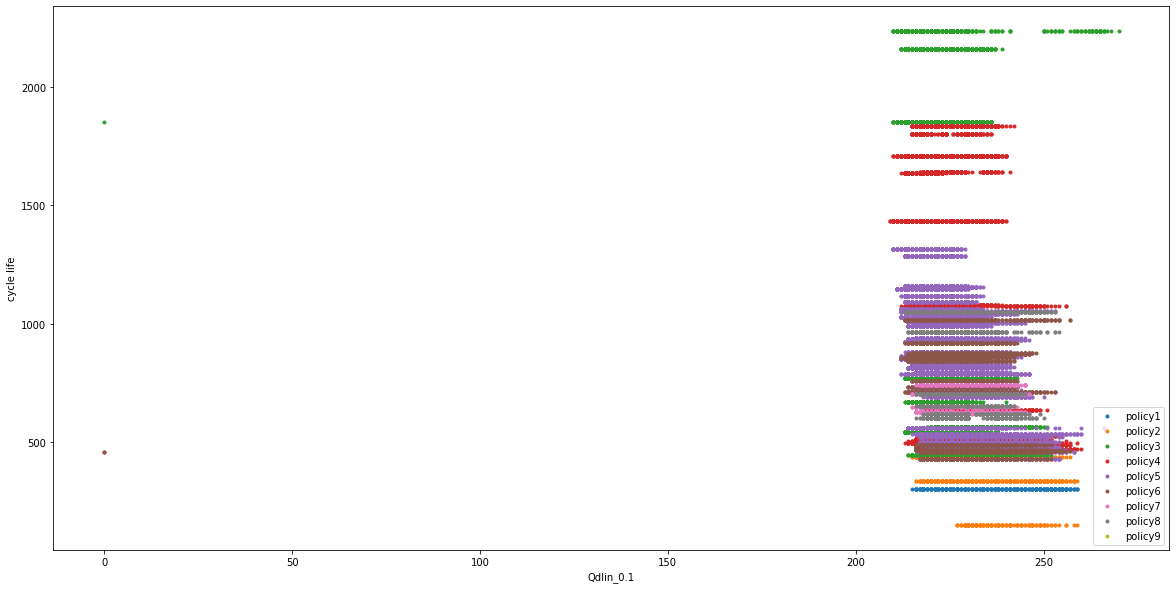

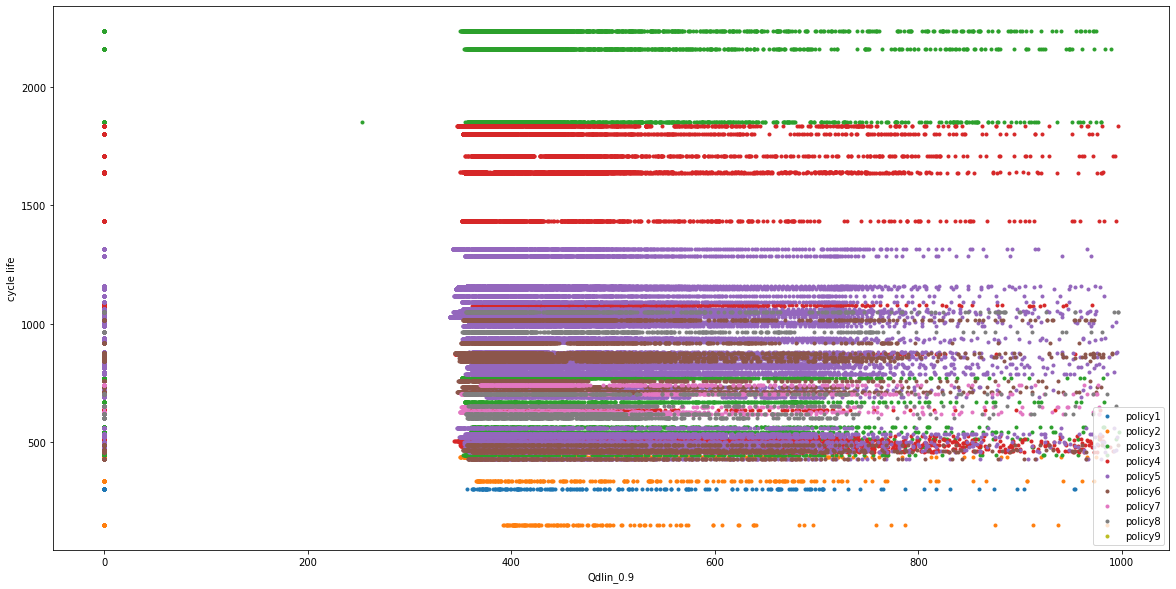

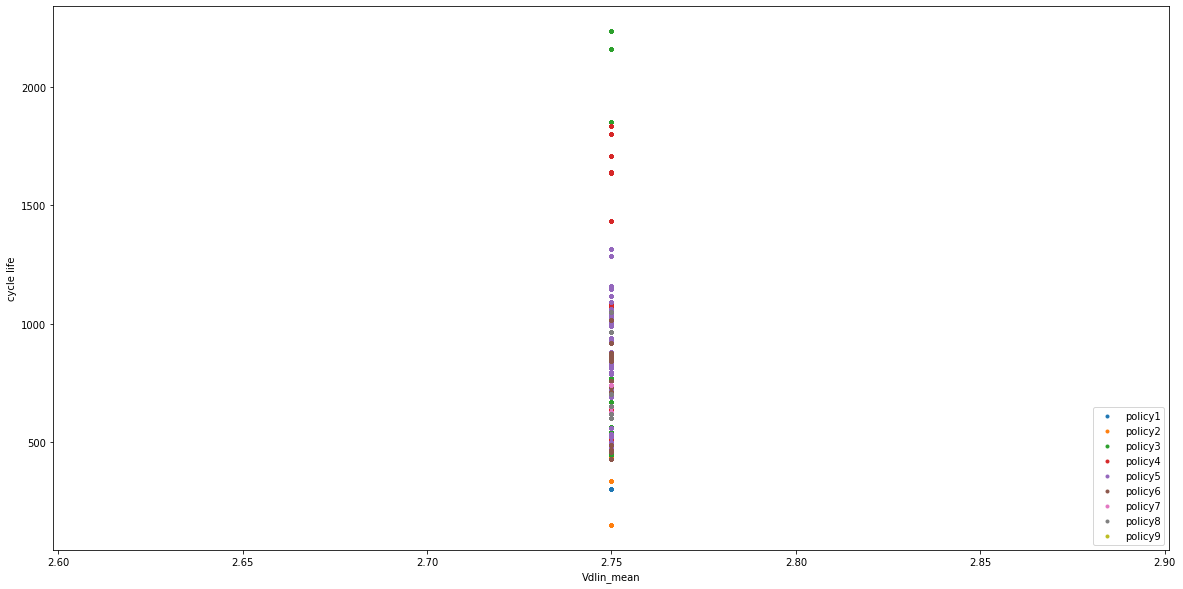

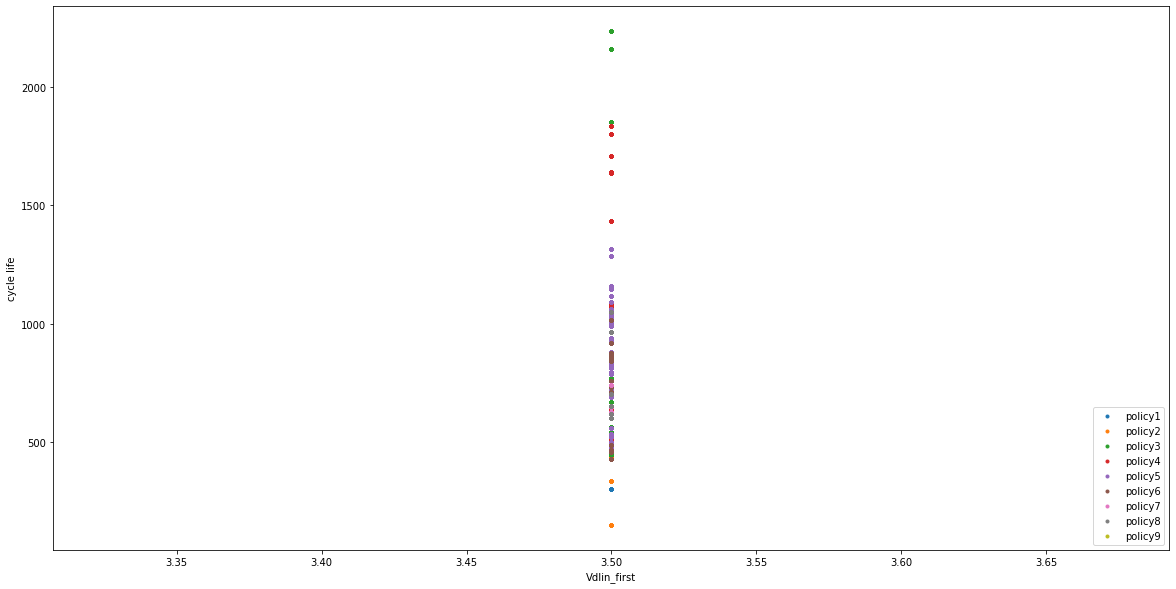

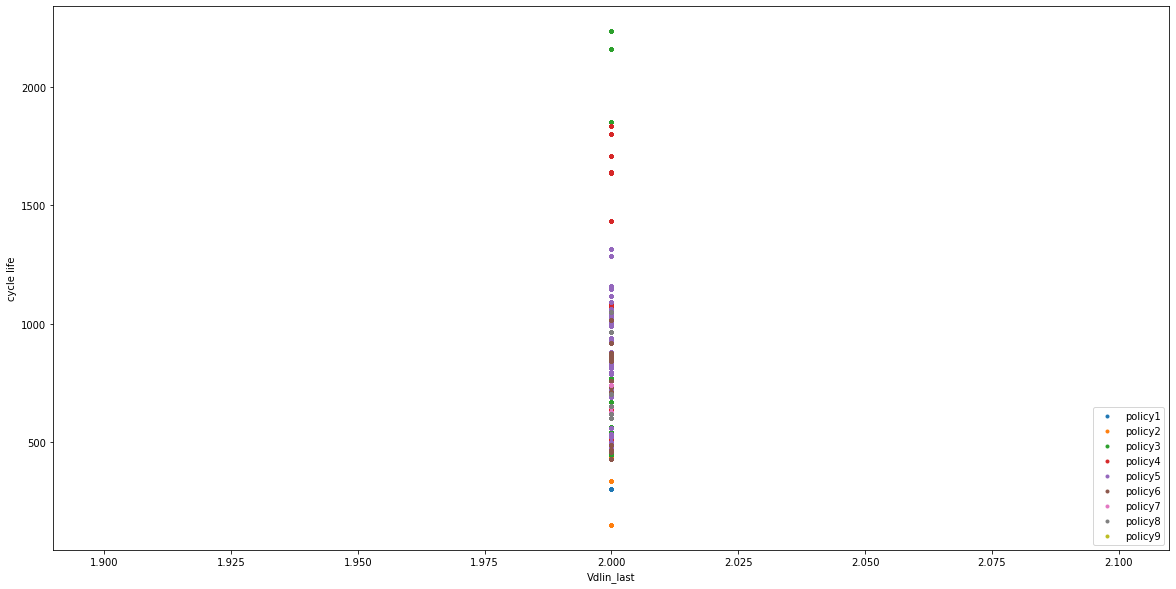

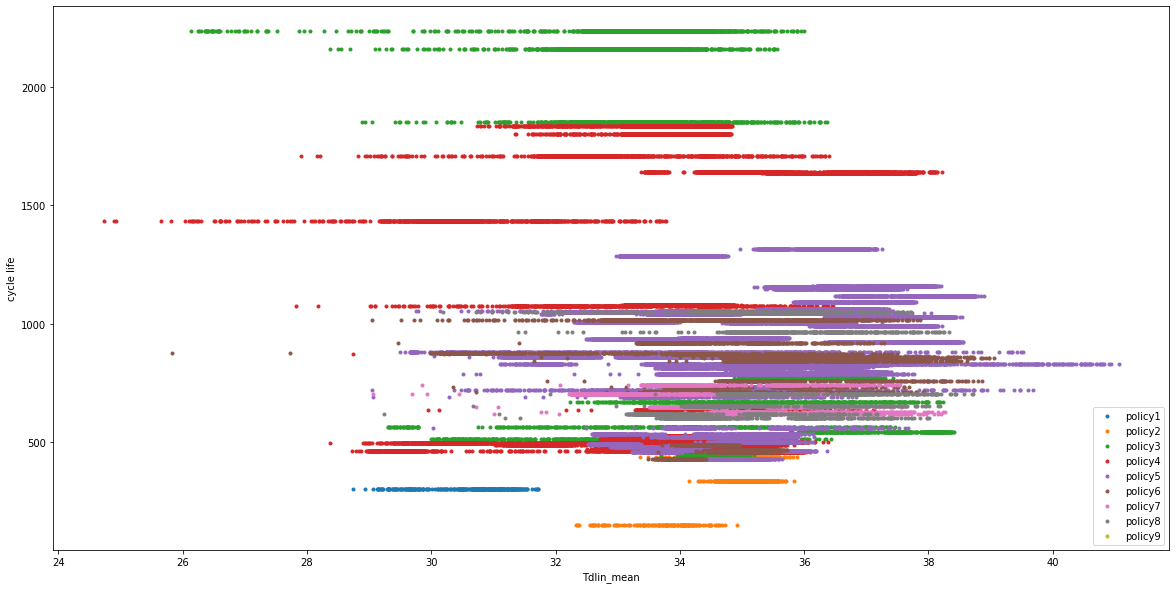

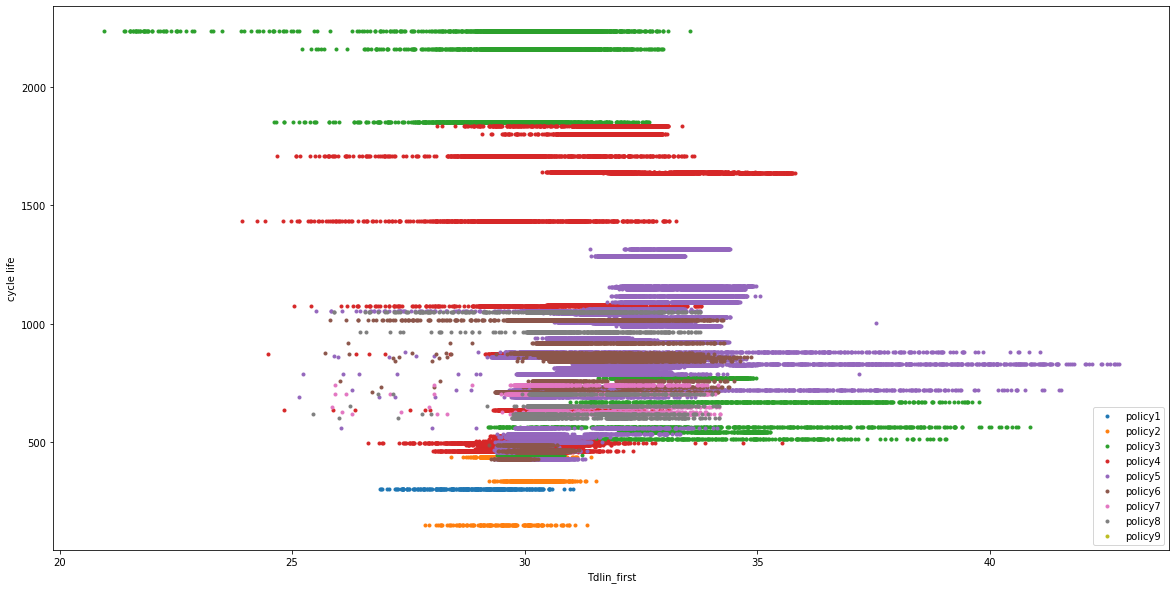

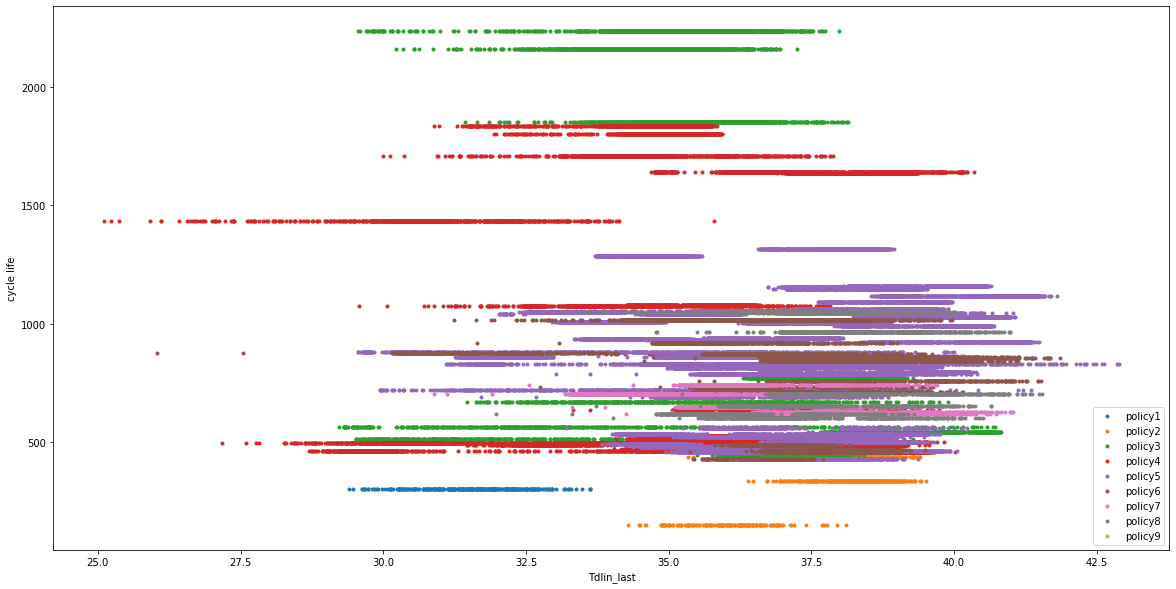

In [24]:
# Some plots of cycle_life = f(features)

df_plots = df.drop(['Remaining_cycles', 'Qdlin', 'Tdlin', 'Vdlin'], axis=1)
df_pol = [df_plots.loc[df_plots.policy == i] for i in range(9)]
for feature in df_plots.columns:
    fig, ax = plt.subplots(figsize=(20, 10))
    for policy, dataframe in enumerate(df_pol):
        plt.scatter(dataframe[feature], dataframe.cycle_life, marker='.', label=f'policy{policy+1}')
    plt.xlabel(feature)
    plt.ylabel('cycle life')
    plt.legend(loc="lower right")

In [25]:
# Amount of cells with each policy in the dataset
df.groupby(level='cell').policy.min().value_counts()

4    54
3    27
5    17
2    10
6     6
7     6
1     3
0     1
Name: policy, dtype: int64

In [26]:
# Lets work with policies 2, 3, 4 and 5, we have 10 or more cells in our dataset with these policies
df = df.loc[df.policy.isin([2, 3, 4, 5])]
df.describe()

,cycle_life,policy,IR,QD,Remaining_cycles,Discharge_time,Qdlin_mean,Qdlin_first,Qdlin_last,Qdlin_median,Qdlin_25p,Qdlin_75p,Qdlin_0.1,Qdlin_0.9,Vdlin_mean,Vdlin_first,Vdlin_last,Tdlin_mean,Tdlin_first,Tdlin_last
count,89001.000000,89001.000000,89001.000000,89001.000000,89001.000000,89001.000000,89001.000000,89001.000000,89001.000000,89001.000000,89001.000000,89001.000000,89001.000000,89001.000000,89001.00,89001.0,89001.0,89001.000000,89001.000000,89001.000000
mean,1001.526758,3.663509,0.016512,1.033044,501.032348,13.544053,0.683357,0.000334,0.993399,0.913535,0.323481,0.978458,223.349850,413.635487,2.75,3.5,2.0,34.627679,31.471843,36.517730
std,465.289916,0.855680,0.001240,0.048443,394.408538,0.874776,0.054838,0.005246,0.064060,0.074417,0.078882,0.064401,7.992115,176.688395,0.00,0.0,0.0,1.798504,1.674112,2.312451
min,429.000000,2.000000,0.000000,0.874198,0.000000,6.280923,0.471727,0.000000,0.746199,0.637856,0.056234,0.729395,0.000000,0.000000,2.75,3.5,2.0,24.737205,20.959980,25.110996
25%,709.000000,3.000000,0.015522,1.016060,207.000000,13.205543,0.657601,0.000040,0.968644,0.876612,0.277704,0.954194,218.000000,377.000000,2.75,3.5,2.0,33.518106,30.199017,35.117550
50%,876.000000,4.000000,0.016387,1.049102,413.000000,13.801295,0.697895,0.000198,1.012265,0.930008,0.344945,0.996888,221.000000,419.000000,2.75,3.5,2.0,34.596379,31.306590,36.677267
75%,1146.000000,4.000000,0.017293,1.066873,700.000000,14.174277,0.723100,0.000544,1.039625,0.966985,0.382018,1.022613,227.000000,488.000000,2.75,3.5,2.0,35.871066,32.510803,38.216843
max,2237.000000,5.000000,0.023757,2.884085,2236.000000,24.197272,1.375299,1.064762,1.527960,1.488830,1.158508,1.520885,270.000000,997.000000,2.75,3.5,2.0,41.062188,42.775010,42.885586


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [28]:
import sklearn
sklearn.__version__

'0.24.0'

In [29]:
# Add cycle_number as feature
# This is known data if the battery is new when received.
if 'cycle_number' not in df.columns:
    df = df.swaplevel().reset_index(level=[0])

Let's create a model which predicts the total cycle life of the battery cell.

In [30]:
y_life = df.cycle_life
X = df.drop(['Remaining_cycles', 'Qdlin', 'Tdlin', 'Vdlin', 'cycle_life'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y_life, test_size=0.2, random_state=13)


rf_life = RandomForestRegressor(
    max_depth=None,
    n_estimators=25,
#     criterion='squared_error',
    random_state=13
)
rf_life.fit(X_train, y_train)

RandomForestRegressor(n_estimators=25, random_state=13)

In [31]:
y_pred_train = rf_life.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f'rmse: {rmse_train}, mae: {mae_train}')

rmse: 9.760449445122212, mae: 1.7760904494382013


In [32]:
y_pred = rf_life.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'rmse: {rmse}, mae: {mae}')

rmse: 23.285953562694626, mae: 4.8081838098983205


In [33]:
pd.DataFrame([rf_life.feature_importances_], columns=X.columns.tolist())

,cycle_number,policy,IR,QD,Discharge_time,Qdlin_mean,Qdlin_first,Qdlin_last,Qdlin_median,Qdlin_25p,Qdlin_75p,Qdlin_0.1,Qdlin_0.9,Vdlin_mean,Vdlin_first,Vdlin_last,Tdlin_mean,Tdlin_first,Tdlin_last
0,0.446194,0.198912,0.069902,0.017541,0.012418,0.028354,0.000061,0.00474,0.011341,0.145914,0.002365,0.004871,0.003574,0.0,0.0,0.0,0.005759,0.017904,0.03015


In [34]:
result_df_life = pd.DataFrame([])
result_df_life['y_test'] = y_test
result_df_life['y_pred'] = y_pred

In [35]:
result_df_life.head()

,y_test,y_pred
cell,,
b2c13,483.0,482.92
b3c18,1146.0,1142.68
b3c40,796.0,796.00
b2c13,483.0,483.00
b2c28,509.0,511.28


In [36]:
result_df_life.sort_values('y_test', inplace=True)

Text(0, 0.5, 'Cycle life')

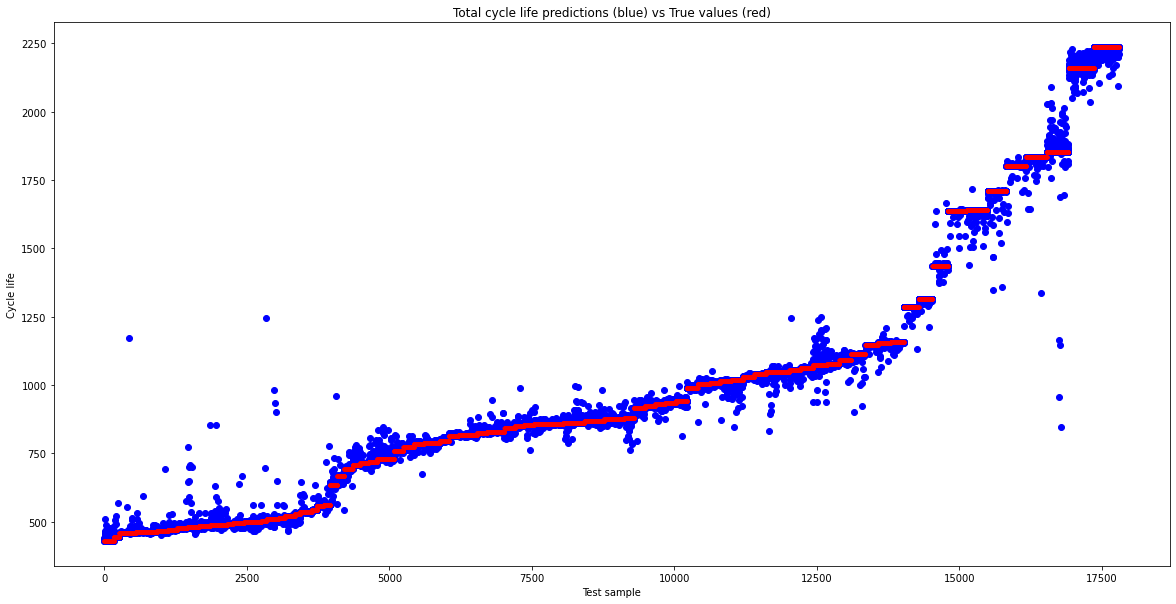

In [37]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(range(len(result_df_life)), result_df_life.y_pred, color='blue')
plt.scatter(range(len(result_df_life)), result_df_life.y_test, color='red', marker='.')
plt.title('Total cycle life predictions (blue) vs True values (red)')
plt.xlabel('Test sample')
plt.ylabel('Cycle life')

In [38]:
result_df_life.corr(method='spearman')

,y_test,y_pred
y_test,1.000000,0.997748
y_pred,0.997748,1.000000


In [39]:
result_df_life.corr(method='pearson')

,y_test,y_pred
y_test,1.000000,0.998749
y_pred,0.998749,1.000000


In [40]:
# [tree.get_depth() for tree in rf_life.estimators_]

Let's now create a model which predicts the amount of remaining cycles of the battery cell

In [41]:
y_remaining_cycles = df.Remaining_cycles
X = df.drop(['Remaining_cycles', 'Qdlin', 'Tdlin', 'Vdlin', 'cycle_life'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y_remaining_cycles, test_size=0.2, random_state=13)


rf_cycles = RandomForestRegressor(
    max_depth=None,
    n_estimators=25,
#     criterion='squared_error',
    random_state=13
)
rf_cycles.fit(X_train, y_train)

RandomForestRegressor(n_estimators=25, random_state=13)

In [42]:
y_pred_train = rf_cycles.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f'rmse: {rmse_train}, mae: {mae_train}')

rmse: 8.025031661528777, mae: 2.423570786516854


In [43]:
y_pred = rf_cycles.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'rmse: {rmse}, mae: {mae}')

rmse: 18.67040023787421, mae: 5.945906409752261


In [44]:
pd.DataFrame([rf_cycles.feature_importances_], columns=X.columns.tolist())

,cycle_number,policy,IR,QD,Discharge_time,Qdlin_mean,Qdlin_first,Qdlin_last,Qdlin_median,Qdlin_25p,Qdlin_75p,Qdlin_0.1,Qdlin_0.9,Vdlin_mean,Vdlin_first,Vdlin_last,Tdlin_mean,Tdlin_first,Tdlin_last
0,0.088336,0.10351,0.047339,0.027951,0.007056,0.012907,0.000099,0.0035,0.551248,0.042562,0.003951,0.001365,0.074708,0.0,0.0,0.0,0.004097,0.004803,0.026569


In [45]:
result_df_cycles = pd.DataFrame([])
result_df_cycles['y_test'] = y_test
result_df_cycles['y_pred'] = y_pred

In [46]:
result_df_cycles.head()

,y_test,y_pred
cell,,
b2c13,45.0,45.12
b3c18,497.0,494.88
b3c40,661.0,661.00
b2c13,196.0,195.12
b2c28,11.0,12.48


In [47]:
result_df_cycles.sort_values('y_test', inplace=True)

In [48]:
len(result_df_cycles)

17801

Text(0, 0.5, 'Remaining cycle life')

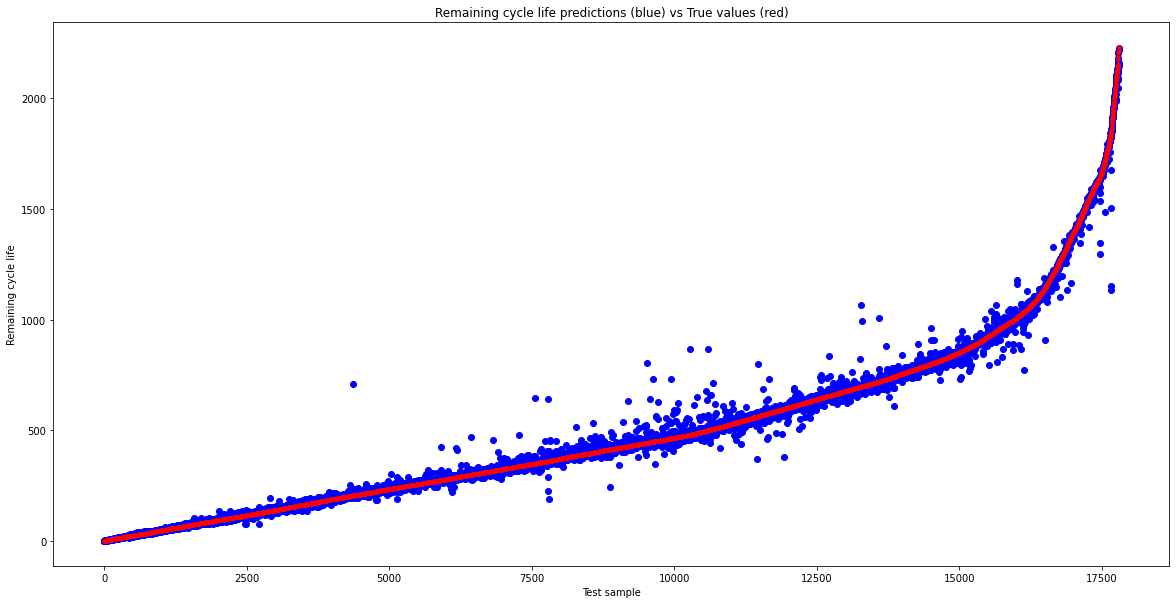

In [49]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(range(len(result_df_cycles)), result_df_cycles.y_pred, color='blue')
plt.scatter(range(len(result_df_cycles)), result_df_cycles.y_test, color='red', marker='.')
plt.title('Remaining cycle life predictions (blue) vs True values (red)')
plt.xlabel('Test sample')
plt.ylabel('Remaining cycle life')

In [50]:
result_df_cycles.corr(method='spearman')

,y_test,y_pred
y_test,1.000000,0.998952
y_pred,0.998952,1.000000


In [51]:
result_df_cycles.corr(method='pearson')

,y_test,y_pred
y_test,1.000000,0.998887
y_pred,0.998887,1.000000


In [52]:
# [tree.get_depth() for tree in rf_cycles.estimators_]

We will upload the models to waylay

In [53]:
from waylay import WaylayClient
from waylay.service.byoml import ByomlActionError

In [54]:
import waylay
waylay.__version__

'v0.4.0'

In [55]:
waylay_client = WaylayClient.from_profile('demo')

In [56]:
model_name_battery_life = 'battery-total-life'
model_name_battery_cycles = 'battery-remaining-cycles'

In [57]:
try:
    waylay_client.byoml.model.remove(model_name_battery_life)
    print('Total battery life model deleted')
except:
    print('Total battery life model does not exist')

try:
    waylay_client.byoml.model.remove(model_name_battery_cycles)
    print('Remaining battery cycles model deleted')
except:
    print('Remaining cycles model does not exist')

Total battery life model deleted
Remaining battery cycles model deleted


In [58]:
try:
    waylay_client.byoml.model.upload(
        model_name=model_name_battery_life, 
        trained_model=rf_life, 
        framework='sklearn',
        description='Battery cell total cycle life prediction.'
    )
except ByomlActionError as e:
    print('Ignored ByomlActionError 502')
    print(e)

In [59]:
waylay_client.byoml.model.list(params={'name':model_name_battery_life})

[{'createdBy': 'users/f16ccae4-8f0f-4f39-912b-5c2cb13ff6b6',
  'createdOn': '2021-11-24T09:47:32.767000+00:00',
  'description': 'Battery cell total cycle life prediction.',
  'framework': 'sklearn',
  'framework_version': '0.24',
  'metadata': {'description': 'Battery cell total cycle life prediction.'},
  'name': 'battery-total-life',
  'updatedBy': 'users/f16ccae4-8f0f-4f39-912b-5c2cb13ff6b6',
  'updatedOn': '2021-11-24T09:47:32.767000+00:00',
  'version': '1'}]

In [60]:
try:
    waylay_client.byoml.model.upload(
        model_name=model_name_battery_cycles, 
        trained_model=rf_cycles, 
        framework='sklearn',
        description='Battery cell remaining cycle life prediction.'
    )
except ByomlActionError as e:
    print('Ignored ByomlActionError 502')
    print(e)

Ignored ByomlActionError 502
ByomlActionError(502: 'operation=server_error'; POST 'https://byoml.waylay.io/models')


In [61]:
waylay_client.byoml.model.list(params={'name':model_name_battery_cycles})

[]

We will create a csv file out of X_test to be used together with the uploaded byoml model by sending the data to Labs.

In [62]:
from datetime import timedelta
import csv
etl_tool = waylay_client.timeseries.etl_tool
X_test.to_csv('battery-life-testset.csv', index=True)

In [63]:
waylay_client.byoml.model.get(model_name_battery_life, retry_until_ready=True)

{'createdBy': 'users/f16ccae4-8f0f-4f39-912b-5c2cb13ff6b6',
 'createdOn': '2021-11-24T09:47:32.767000+00:00',
 'description': 'Battery cell total cycle life prediction.',
 'framework': 'sklearn',
 'framework_version': '0.24',
 'metadata': {'description': 'Battery cell total cycle life prediction.'},
 'name': 'battery-total-life',
 'ready': True,
 'supported_endpoints': ['predict'],
 'updatedBy': 'users/f16ccae4-8f0f-4f39-912b-5c2cb13ff6b6',
 'updatedOn': '2021-11-24T09:47:32.767000+00:00',
 'version': '1'}

In [65]:
waylay_client.byoml.model.get(model_name_battery_cycles, retry_until_ready=True)

{'createdBy': 'users/f16ccae4-8f0f-4f39-912b-5c2cb13ff6b6',
 'createdOn': '2021-11-24T09:49:43.180000+00:00',
 'description': 'Battery cell remaining cycle life prediction.',
 'framework': 'sklearn',
 'framework_version': '0.24',
 'metadata': {'description': 'Battery cell remaining cycle life prediction.'},
 'name': 'battery-remaining-cycles',
 'ready': True,
 'supported_endpoints': ['predict'],
 'updatedBy': 'users/f16ccae4-8f0f-4f39-912b-5c2cb13ff6b6',
 'updatedOn': '2021-11-24T09:49:43.180000+00:00',
 'version': '1'}

In [66]:
waylay_client.byoml.model.predict(model_name_battery_life, X_test)

array([ 482.92, 1142.68,  796.  , ..., 1054.  ,  487.  , 1434.  ])

In [67]:
waylay_client.byoml.model.predict(model_name_battery_cycles, X_test)

array([ 45.12, 494.88, 661.  , ...,  61.64,  25.  , 527.76])